## Project: Data Wrangling & Analysis using tweepy to get WeRateDog tweet data from twitter API


* Introduction
* Data Wrangling via tweepy
* Data Cleaning
* Data Analysis and Visualization
* Conclusion


### Introduction

I will be wrangling (and analyzing and visualizing) the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also know as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because [they're good dogs Brent.](http://knowyourmeme.com/memes/theyre-good-dogs-brent) WeRateDogs has over 4 million followers and has received international media coverage.

My tasks in this project are as follows:
1. Gathering data
2. Assessing data
3. Cleaning data
4. Storing data
5. Analyzing, and visualizing data
6. Reporting

In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import requests
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
from PIL import Image
from io import BytesIO


## DATA WRANGLING
#### Gathering data

Load and review the archive data provided by Udacity

In [2]:
df1 = pd.read_csv('./twitter-archive-enhanced.csv')
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
df1.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [5]:
df1.name.tail(10)

2346     the
2347       a
2348       a
2349      an
2350       a
2351    None
2352       a
2353       a
2354       a
2355    None
Name: name, dtype: object

In [6]:
df1['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [7]:
df1['rating_numerator'].unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

#### Image Prediction File

This image prediction file is a neural network that is present in each tweet. It is hosted on Udacity's server and will be downloaded programmatically using Requests library.

In [8]:
# Get the url and confirmed if successfull

r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
r.status_code

200

In [9]:
#View the the content of the file

r.content

b"tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog\n666020888022790149\thttps://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg\t1\tWelsh_springer_spaniel\t0.465074\tTrue\tcollie\t0.156665\tTrue\tShetland_sheepdog\t0.0614285\tTrue\n666029285002620928\thttps://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg\t1\tredbone\t0.506826\tTrue\tminiature_pinscher\t0.07419169999999999\tTrue\tRhodesian_ridgeback\t0.07201\tTrue\n666033412701032449\thttps://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg\t1\tGerman_shepherd\t0.596461\tTrue\tmalinois\t0.13858399999999998\tTrue\tbloodhound\t0.11619700000000001\tTrue\n666044226329800704\thttps://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg\t1\tRhodesian_ridgeback\t0.408143\tTrue\tredbone\t0.360687\tTrue\tminiature_pinscher\t0.222752\tTrue\n666049248165822465\thttps://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg\t1\tminiature_pinscher\t0.560311\tTrue\tRottweiler\t0.243682\tTrue\tDoberman\t0.154629\tTrue\n666050758794694657\thttps://pbs.twimg.com/

In [10]:
#Save the file to the computer

open('image-predict.tsv', 'wb').write(r.content)

335079

In [11]:
predict = pd.read_csv('image-predict.tsv', sep='\t')
predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
predict.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

#### Twitter API-json file

Through the use of tweepy (python libary), we will query the twitter Api for additional data beyond the ones included in the WeRateDog archive. This additional data will include retweet count and favourite count.

In [14]:
# Count the total tweet_id's in the archive data provided by Udacity above

tweet_ids = df1.tweet_id.values
len(tweet_ids)

2356

This line of code below will run provided there is an auth access for twitter developer account. I make use of the scraped data sent to me by Udacity because Twitter declined my access.

In [15]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
#    consumer_key = ''
#    consumer_secret = ''
#    access_token = ''
#    access_secret = ''
#
#    auth = OAuthHandler(consumer_key, consumer_secret)
#    auth.set_access_token(access_token, access_secret)
#
#    api = tweepy.API(auth, wait_on_rate_limit=True)
#
#    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#    start = timer()
#   # Save each tweet's returned JSON as a new line in a .txt file
#    with open('tweet_json.txt', 'w') as outfile:
#        for tweet_id in tweet_ids:
#            count += 1
#            print(str(count) + ": " + str(tweet_id))
#            try:
#                tweet = api.get_status(tweet_id, tweet_mode='extended')
#                print("Success")
#                json.dump(tweet._json, outfile)
#                outfile.write('\n')
#            except tweepy.TweepError as e:
#                print("Fail")
#                fails_dict[tweet_id] = e
#                pass
#    end = timer()
#    print(end - start)
#    print(fails_dict)
#


In [16]:
# Open an empty list to append the txt data 

tweet = []
with open('tweet-json.txt', 'r') as f:
    for line in f:
        status = json.loads(line)
        
        # Append to list of dictionaries
        tweet.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'created_at': status['created_at'],
                        'display_text_range': status['display_text_range']
                       })

In [17]:
status

{'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'id': 666020888022790149,
 'id_str': '666020888022790149',
 'full_text': 'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj',
 'truncated': False,
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 666020881337073664,
    'id_str': '666020881337073664',
    'indices': [108, 131],
    'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'url': 'https://t.co/BLDqew2Ijj',
    'display_url': 'pic.twitter.com/BLDqew2Ijj',
    'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 340, 'h': 255, 'resize': 'fit'},
     'medium': {'w': 600, 'h': 450, 'resize': 'fit

In [18]:
# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
tweepy_df = pd.DataFrame(tweet, columns = ['tweet_id', 'retweet_count', 'favorite_count','created_at', 'display_text_range'])
tweepy_df.head()

,tweet_id,retweet_count,favorite_count,created_at,display_text_range
0,892420643555336193,8853,39467,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]"
1,892177421306343426,6514,33819,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]"
2,891815181378084864,4328,25461,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]"
3,891689557279858688,8964,42908,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]"
4,891327558926688256,9774,41048,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]"


In [19]:
tweepy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   created_at          2354 non-null   object
 4   display_text_range  2354 non-null   object
dtypes: int64(3), object(2)
memory usage: 92.1+ KB


#### Assessing Data
* <b>Quality</b>
1. False datatype - id's shouldn't be int and timestamp not object type
2. Duplicate data on df1 (Twitter archive table)
3. The tables does not contain the same amount of tweet_id's, 2075 in predict table while more in the archive table.
4. Untidy data in the source column contains html tag $(<a></a>)$
5. Dog name like a, an, none not extracted well (Programmatically)
6. Unneeded columns should be deleted (drop)
7. Alphabet format should be constant (not small letter starting some while capital letter state the other).
8. Different rating_denominator, which mean different rating standard which i will like to be fixed to 10 as that is the common stardard.
* <b>Tidiness</b>
1.  The last 4 columns (doggo,floofer, pupper & puppo) in df1 are dog stages which should be collapse into one column (Each variable forms a column). And None are replace with empty space (Null_value)
2. The three dataframe (df1,predict, tweepy_df) needs to be merge.

## DATA CLEANING
#### Cleaning data

In [20]:
# Copies of dataframe for cleaning

df1_clean = df1.copy()
predict_clean = predict.copy()
tweepy_clean = tweepy_df.copy()

* Convert the datatype to the correct type 

In [21]:
df1_clean['timestamp'] = pd.to_datetime(df1_clean['timestamp'])
tweepy_clean['created_at'] = pd.to_datetime(tweepy_clean['created_at'])

In [22]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

* Clean out the tweet_id that is not in the predict table

In [23]:
df1_clean = df1_clean[df1_clean['tweet_id'].isin(predict_clean['tweet_id'])]

In [24]:
len(df1_clean)

2075

* Merge the last 4 columns into one column called growth

In [25]:
#df1_clean['growth'] = df1_clean[['doggo','floofer','pupper','puppo']].melt()

growth = ['doggo','pupper', 'floofer', 'puppo' ]
for i in growth:
        df1_clean[i] = df1_clean[i].replace('None', '')
        
# Use concatenate
df1_clean['growth'] = df1_clean.doggo.str.cat(df1_clean.floofer).str.cat(df1_clean.pupper).str.cat(df1_clean.puppo)

# drop the four old colomns
df1_clean = df1_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

# use np.nan to fill the empty
df1_clean['growth'] = df1_clean['growth'].replace('', np.nan)        

In [26]:
df1_clean['growth'].value_counts()

pupper          211
doggo            67
puppo            23
doggopupper      11
floofer           7
doggopuppo        1
doggofloofer      1
Name: growth, dtype: int64

In [27]:
# Serperate the dogs that have two stages

df1_clean.loc[df1_clean.growth == 'doggopupper', 'growth'] = 'doggo, pupper'
df1_clean.loc[df1_clean.growth == 'doggopuppo', 'growth'] = 'doggo, puppo'
df1_clean.loc[df1_clean.growth == 'doggofloofer', 'growth'] = 'doggo, floofer'

# Replace None with empty space
df1_clean['growth'] = df1_clean['growth'].replace('None', '')
df1_clean.loc[df1_clean.growth == '', 'growth'] = np.nan

In [28]:
df1_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,growth
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [29]:
df1_clean['growth'].value_counts()

pupper            211
doggo              67
puppo              23
doggo, pupper      11
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: growth, dtype: int64

* Erroneous dog names - Change all lowercase characters to none as the dog's name are all written in uppercase except where there is no name. And we can see from check that some dogs with name are also 'None'. 

In [30]:
check = df1_clean[df1_clean['name'] == 'None']
check[['tweet_id','text','name']].head(7)
len(check)

578

In [32]:
df1_clean.loc[df1_clean.name.str.match('[a-z]+')] = 'None'

# Make every None an empty space(Null)
df1_clean['name'] = df1_clean['name'].replace('None', '')
df1_clean.loc[df1_clean.name == '', 'name'] = np.nan

In [33]:
# Test

len(df1_clean[df1_clean['name'] == 'None'])

0

* Column that won't be use for analysis will be cleaned out (deleted)

In [34]:
df1_clean = df1_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

In [35]:
df1_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN


* The character format is needs to be uniform. 

In [36]:
df1_clean['name'].str.islower().sum()

0

In [37]:
df1_clean['growth'].str.islower().sum()

308

In [38]:
df1_clean['growth'] = df1_clean['growth'].str.capitalize()
df1_clean['growth'].str.islower().sum()

0

* Different rating_denominator, which mean different rating standard needs to be fixed to 10 as that is the common stardard.

In [39]:
pd.set_option('max_colwidth',150)
check2 = df1_clean[df1_clean['rating_denominator'] != 10]
check2[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
22,None,None,None,None
56,None,None,None,None
169,None,None,None,None
193,None,None,None,None
369,None,None,None,None
...,...,...,...,...
2349,None,None,None,None
2350,None,None,None,None
2352,None,None,None,None
2353,None,None,None,None


Looking at the table above, there are some rows that have 10 as denominator but wrongly extracted. I will correct this.

In [40]:
df1_clean.loc[df1_clean.tweet_id == 722974582966214656, ['rating_denominator']] = 10
df1_clean.loc[df1_clean.tweet_id == 682962037429899265, ['rating_denominator']] = 10
df1_clean.loc[df1_clean.tweet_id == 666287406224695296, ['rating_denominator']] = 10


#### Tidiness

Unnecessary html tags in the source column will be clean out

In [42]:
df1_clean['source'] = df1_clean['source'].str.replace(r'<(?:a\b[^>]*>|/a>)', '')
df1_clean['source'] = df1_clean['source'].astype('category')

df1_clean['source'] = df1_clean['source'].replace('None', '')
df1_clean.loc[df1_clean.growth == '', 'source'] = np.nan

<ipython-input-42-637d830272dc>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df1_clean['source'] = df1_clean['source'].str.replace(r'<(?:a\b[^>]*>|/a>)', '')


In [43]:
df1_clean.source.head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: category
Categories (4, object): ['', 'TweetDeck', 'Twitter Web Client', 'Twitter for iPhone']

In [44]:
df1_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,NaN


#### Merge the three data set together (df1_clean, predict_clean, tweepy_clean)

In [45]:
merge1 = pd.merge(df1_clean, 
                      predict_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)

merge1 = merge1[merge1['jpg_url'].notnull()]

In [46]:
merge1.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [47]:
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2074
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1975 non-null   object  
 1   timestamp           1975 non-null   object  
 2   source              1975 non-null   category
 3   text                1975 non-null   object  
 4   rating_numerator    1975 non-null   object  
 5   rating_denominator  1975 non-null   object  
 6   name                1397 non-null   object  
 7   growth              308 non-null    object  
 8   jpg_url             1975 non-null   object  
 9   img_num             1975 non-null   float64 
 10  p1                  1975 non-null   object  
 11  p1_conf             1975 non-null   float64 
 12  p1_dog              1975 non-null   object  
 13  p2                  1975 non-null   object  
 14  p2_conf             1975 non-null   float64 
 15  p2_dog              1975 non-null   ob

In [48]:
full_merge = pd.merge(merge1, 
                      tweepy_clean, 
                      how = 'left', on = ['tweet_id'])

In [49]:
full_merge.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth,jpg_url,img_num,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at,display_text_range
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,2017-08-01 16:23:56+00:00,"[0, 85]"
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,Pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,2017-08-01 00:17:27+00:00,"[0, 138]"
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0,2017-07-31 00:18:03+00:00,"[0, 121]"
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0,2017-07-30 15:58:51+00:00,"[0, 79]"
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774.0,41048.0,2017-07-29 16:00:24+00:00,"[0, 138]"


In [50]:
full_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 1974
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1975 non-null   object             
 1   timestamp           1975 non-null   object             
 2   source              1975 non-null   category           
 3   text                1975 non-null   object             
 4   rating_numerator    1975 non-null   object             
 5   rating_denominator  1975 non-null   object             
 6   name                1397 non-null   object             
 7   growth              308 non-null    object             
 8   jpg_url             1975 non-null   object             
 9   img_num             1975 non-null   float64            
 10  p1                  1975 non-null   object             
 11  p1_conf             1975 non-null   float64            
 12  p1_dog              1975 non-null 

### Store the clean-merge data to computer

In [ ]:
full_merge.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

## ANALYZING & VISUALIZING DATA

I will be providing an answer to the following questions below in this analysis section:
* Which twitter source is the most used?
* How have WeRateDogs twitter handle being posting over time?
* Most common dog names
* Which breed is the most popular?
* Dogs retweet and favourite count

In [51]:
count_s = full_merge['source'].value_counts()
count_s

Twitter for iPhone    1938
Twitter Web Client      27
TweetDeck               10
                         0
Name: source, dtype: int64

<AxesSubplot:title={'center':'Most Used Twitter Source'}>

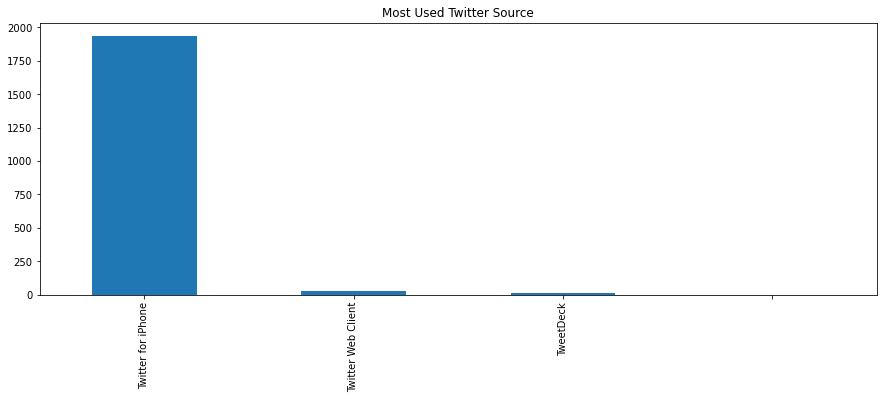

In [52]:
count_s.plot(kind='bar', figsize=(15,5) , title='Most Used Twitter Source')

### Answer 1

The most used twitter source is the iphone as shown above

In [53]:
year_post = full_merge['created_at'].apply(lambda x: x.strftime('%Y')).value_counts().sort_values(ascending = False)
year_post

2016    984
2015    608
2017    381
Name: created_at, dtype: int64

In [54]:
month_post = full_merge['created_at'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_values(ascending = True)
month_post

2017-08      2
2017-04     43
2017-05     45
2017-06     46
2017-07     48
2016-04     52
2016-05     53
2017-03     53
2016-08     60
2016-12     60
2017-02     67
2016-09     69
2016-11     69
2016-10     70
2016-06     72
2017-01     77
2016-07     91
2016-02    103
2016-03    119
2016-01    166
2015-11    262
2015-12    346
Name: created_at, dtype: int64

<AxesSubplot:title={'center':'Year with most Post'}, ylabel='created_at'>

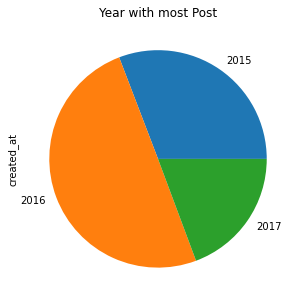

In [55]:
year_post.sort_index(ascending = True).plot(kind= 'pie', figsize=(10,5) , title='Year with most Post')

<AxesSubplot:title={'center':'Month with most Post'}>

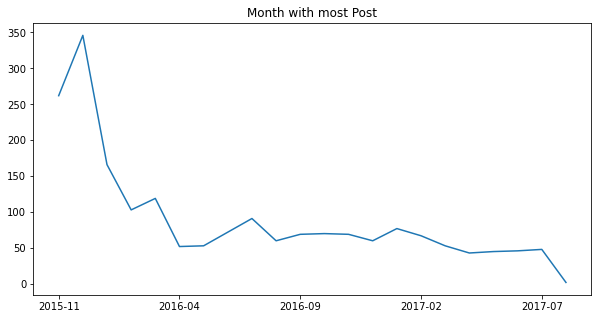

In [56]:
month_post.sort_index(ascending = True).plot(kind= 'line', figsize=(10,5) , title='Month with most Post')

### Answer 2

The year that WeRateDog twitter handle post the most was 2016 while the month happen to be December of 2015.

But If we look at the months data deeply, we will observe that the data provided started from November 2015 while the other 2 years almost have their months complete. This is the month the Twitter handle started which means she tweeted a lot in her early days which decline over time.

In [57]:
common_name = full_merge['name'].value_counts()[:10]
common_name

Charlie    11
Tucker     10
Lucy       10
Oliver     10
Penny      10
Cooper     10
Lola        8
Bo          8
Winston     8
Sadie       8
Name: name, dtype: int64

Text(0.5, 0, 'Number of Dogs')

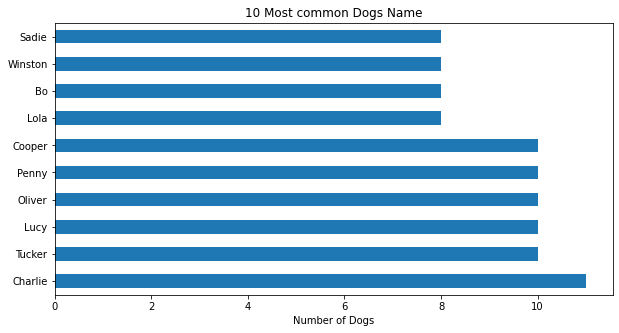

In [58]:
common_name.plot(kind='barh', figsize=(10,5) , title='10 Most common Dogs Name').set_xlabel('Number of Dogs')

### Answer 3

The most common dog name is Charlie

In [59]:
full_merge['p1'] = full_merge['p1'].str.capitalize()
breed = full_merge['p1'].value_counts()[:10]
breed

Golden_retriever      145
Labrador_retriever     97
Pembroke               85
Chihuahua              81
Pug                    54
Chow                   41
Samoyed                41
Pomeranian             36
Toy_poodle             35
Cocker_spaniel         29
Name: p1, dtype: int64

<AxesSubplot:title={'center':'Popular Dog Breed'}>

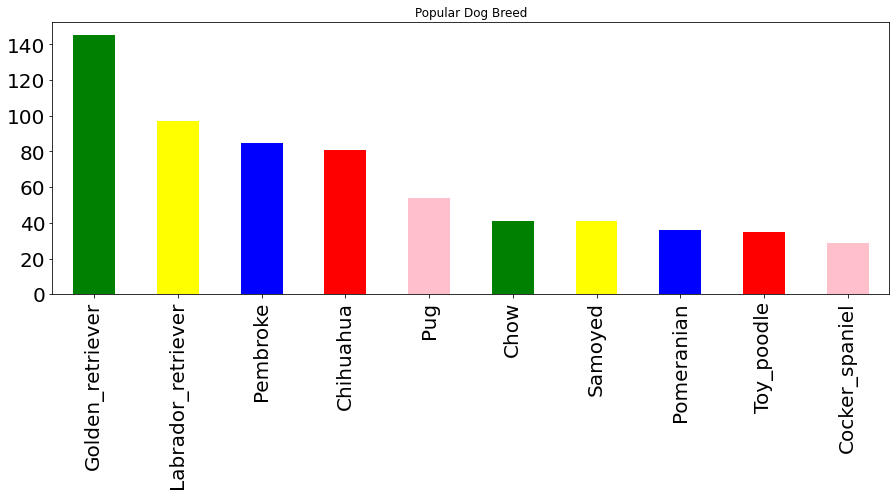

In [60]:
col = ['green','yellow','blue', 'red','pink']
breed.plot(kind='bar', figsize=(15,5), title='Popular Dog Breed', color = (col), fontsize=20)

### Answer 4

From the diagram above, The Golden_retriever breed is the most popular breed among the dogs in this data.

Futhermore, below i will be finding the dog in this breed with the most favorite_count and retweet_count

In [61]:
golden_df = full_merge.query('p1 == "Golden_retriever"')
golden_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth,jpg_url,img_num,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at,display_text_range
14,889531135344209921,2017-07-24 17:02:04+00:00,Twitter for iPhone,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,13,10,Stuart,Puppo,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1.0,...,Labrador_retriever,0.013834,True,redbone,0.007958,True,2321.0,15359.0,2017-07-24 17:02:04+00:00,"[0, 118]"
16,888917238123831296,2017-07-23 00:22:39+00:00,Twitter for iPhone,This is Jim. He found a fren. Taught him how to sit like the good boys. 12/10 for both https://t.co/chxruIOUJN,12,10,Jim,NaN,https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg,1.0,...,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True,4709.0,29611.0,2017-07-23 00:22:39+00:00,"[0, 86]"
17,888804989199671297,2017-07-22 16:56:37+00:00,Twitter for iPhone,This is Zeke. He has a new stick. Very proud of it. Would like you to throw it for him without taking it. 13/10 would do my best https://t.co/HTQ7...,13,10,Zeke,NaN,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1.0,...,Labrador_retriever,0.184172,True,English_setter,0.073482,True,4559.0,26080.0,2017-07-22 16:56:37+00:00,"[0, 128]"
40,883482846933004288,2017-07-08 00:28:19+00:00,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10,Bella,NaN,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1.0,...,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,10407.0,46860.0,2017-07-08 00:28:19+00:00,"[0, 112]"
42,883117836046086144,2017-07-07 00:17:54+00:00,Twitter for iPhone,"Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E",13,10,NaN,NaN,https://pbs.twimg.com/media/DEF2-_hXoAAs62q.jpg,2.0,...,Labrador_retriever,0.045948,True,kuvasz,0.002471,True,6949.0,37914.0,2017-07-07 00:17:54+00:00,"[0, 111]"


In [62]:
golden_df = golden_df.sort_values(by = 'favorite_count', ascending = False)
golden_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth,jpg_url,img_num,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at,display_text_range
95,870374049280663552,2017-06-01 20:18:38+00:00,Twitter for iPhone,This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https:...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,1.0,...,Great_Pyrenees,0.099278,True,Labrador_retriever,0.032621,True,27680.0,85011.0,2017-06-01 20:18:38+00:00,"[0, 139]"
494,795464331001561088,2016-11-07 03:14:10+00:00,Twitter for iPhone,Elder doggo does a splash. Both 13/10 incredible stuff https://t.co/gBUDjdEcqz,13,10,NaN,Doggo,https://pbs.twimg.com/ext_tw_video_thumb/795464066940764160/pu/img/jPkMMQXdydb7CqFX.jpg,1.0,...,Chesapeake_Bay_retriever,0.157927,True,soft-coated_wheaten_terrier,0.124684,True,27728.0,55683.0,2016-11-07 03:14:10+00:00,"[0, 54]"
191,846514051647705089,2017-03-28 00:07:32+00:00,Twitter for iPhone,This is Barney. He's an elder doggo. Hitches a ride when he gets tired. Waves goodbye before he leaves. 13/10 please come back soon https://t.co/c...,13,10,Barney,Doggo,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg,2.0,...,Leonberg,0.065199,True,Norfolk_terrier,0.052955,True,13076.0,48410.0,2017-03-28 00:07:32+00:00,"[0, 131]"
40,883482846933004288,2017-07-08 00:28:19+00:00,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10,Bella,NaN,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1.0,...,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,10407.0,46860.0,2017-07-08 00:28:19+00:00,"[0, 112]"
46,882268110199369728,2017-07-04 16:01:23+00:00,Twitter for iPhone,This is Alfy. You're witnessing his first watermelon experience. I think it was a success. 13/10 happy 4th Alfy 🇺🇸 https://t.co/fYP5RlutfA,13,10,Alfy,NaN,https://pbs.twimg.com/media/DD5yKdPW0AArzX8.jpg,1.0,...,Labrador_retriever,0.098985,True,cocker_spaniel,0.017199,True,12118.0,45880.0,2017-07-04 16:01:23+00:00,"[0, 114]"


#### Zoey is the dog with the most favorite_count in the Golden_retriever breed, see image below

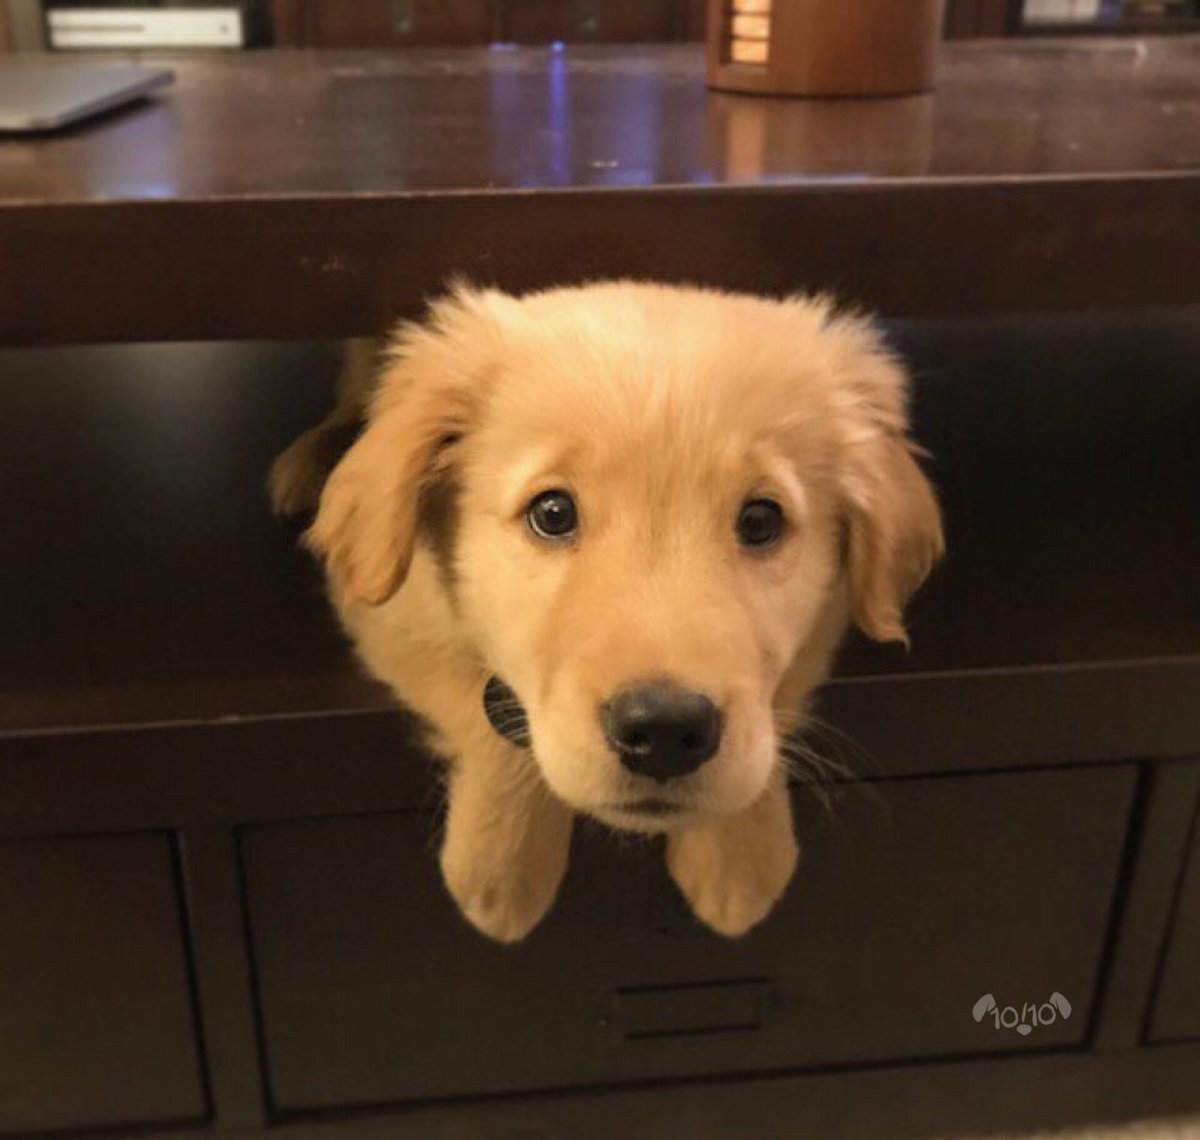

In [63]:
# Get the dog image

url = golden_df['jpg_url'].iloc[0]
r = requests.get(url)
Image.open(BytesIO(r.content))

In [64]:
golden_retw = golden_df.sort_values(by = 'retweet_count', ascending = False)
golden_retw.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,growth,jpg_url,img_num,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,created_at,display_text_range
494,795464331001561088,2016-11-07 03:14:10+00:00,Twitter for iPhone,Elder doggo does a splash. Both 13/10 incredible stuff https://t.co/gBUDjdEcqz,13,10,NaN,Doggo,https://pbs.twimg.com/ext_tw_video_thumb/795464066940764160/pu/img/jPkMMQXdydb7CqFX.jpg,1.0,...,Chesapeake_Bay_retriever,0.157927,True,soft-coated_wheaten_terrier,0.124684,True,27728.0,55683.0,2016-11-07 03:14:10+00:00,"[0, 54]"
95,870374049280663552,2017-06-01 20:18:38+00:00,Twitter for iPhone,This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https:...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,1.0,...,Great_Pyrenees,0.099278,True,Labrador_retriever,0.032621,True,27680.0,85011.0,2017-06-01 20:18:38+00:00,"[0, 139]"
894,733109485275860992,2016-05-19 01:38:16+00:00,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",12,10,NaN,"Doggo, pupper",https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1.0,...,Labrador_retriever,0.042319,True,doormat,0.003956,False,17621.0,44619.0,2016-05-19 01:38:16+00:00,"[0, 50]"
620,775898661951791106,2016-09-14 03:27:11+00:00,Twitter for iPhone,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",12,10,NaN,"Doggo, pupper",https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1.0,...,Labrador_retriever,0.042319,True,doormat,0.003956,False,17621.0,0.0,2016-09-14 03:27:11+00:00,"[0, 89]"
489,796177847564038144,2016-11-09 02:29:25+00:00,Twitter for iPhone,RT @dog_rates: This is Ruby. She just turned on the news. Officially terrified. 11/10 deep breaths Ruby https://t.co/y5KarNXWXt,11,10,Ruby,NaN,https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg,1.0,...,Labrador_retriever,0.140798,True,seat_belt,0.087355,False,16628.0,0.0,2016-11-09 02:29:25+00:00,"[0, 127]"


#### This is the dog with the most retweet_count in the Golden_retriever breed

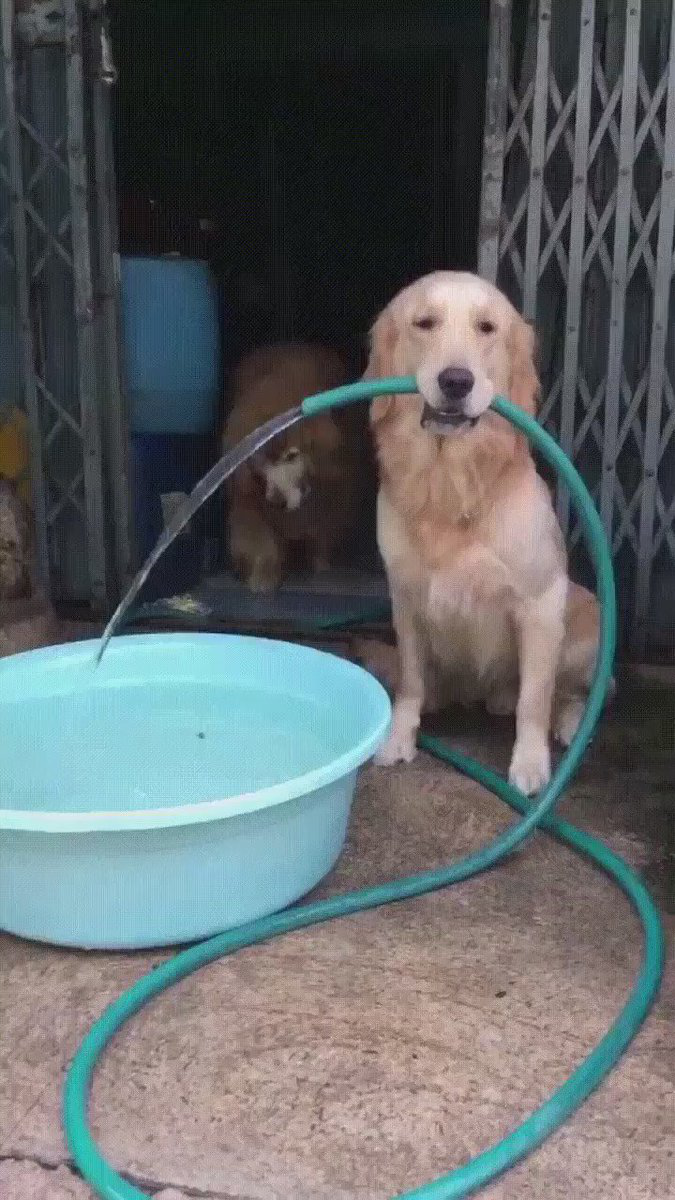

In [65]:
url = golden_retw['jpg_url'].iloc[0]
r = requests.get(url)
Image.open(BytesIO(r.content))

### Answer 4

There is a linear relationship between the retweet_counts and the favorite_counts. The graphs below shows the strong correlation.

<AxesSubplot:title={'center':'Retweets Vs Favorite'}, xlabel='favorite_count', ylabel='retweet_count'>

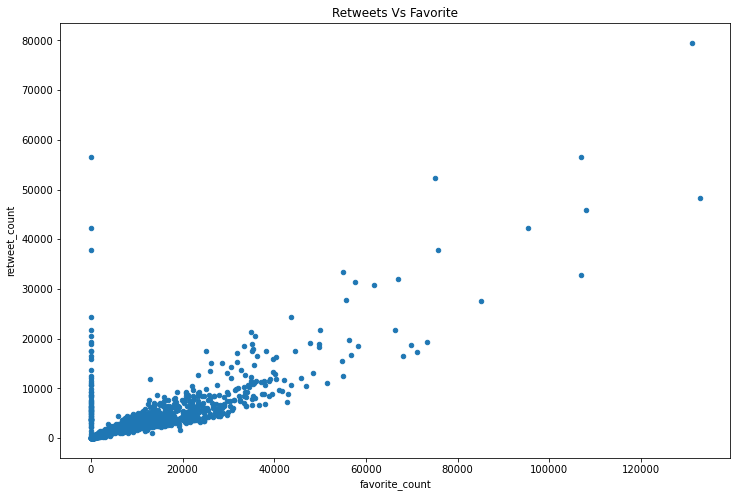

In [66]:
full_merge.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', figsize=(12,8), title = 'Retweets Vs Favorite')


## Conclusion

The experience gathered during the course of this project is great as it honed my data-wrangling skills, scraping the internet(in this case Twitter API), connecting the dots for analysis purposes, and visualizing my findings as seen in the dog image.

From analysis, we can see that people love naming their dogs Charlie, while the popular breed of dogs is the golden_retriever and Zoey is the dog with the most likes (favorite_count). 

WeRateDog Twitter handle posted the most in the year 2016 and most of their engagement happens to come from iPhone users.

[Stackoverflow](https://stackoverflow.com/questions/41386443/create-pandas-dataframe-from-txt-file-with-specific-pattern) is the most reliable place i ran to when stuck doing this project

---
Bamidele